<a href="https://colab.research.google.com/github/Aadil404/Music-Emotion-Recognition/blob/main/notebooks/04_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive


# 2. Define Custom Metric (REQUIRED to load the model)
@tf.keras.utils.register_keras_serializable()
class MultiLabelF1(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision_m = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall_m = tf.keras.metrics.Recall(thresholds=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision_m.update_state(y_true, y_pred, sample_weight)
        self.recall_m.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision_m.result()
        r = self.recall_m.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision_m.reset_states()
        self.recall_m.reset_states()

# 3. Load the Saved Model
print("Loading model...")
model = tf.keras.models.load_model('saved_model/final_crnn_model.keras', custom_objects={'MultiLabelF1': MultiLabelF1})
print("✅ Model loaded successfully!")

Loading model...
✅ Model loaded successfully!


In [5]:
# --- Configuration ---
EMOTIONS = ['amazement', 'solemnity', 'tenderness', 'nostalgia', 'calmness',
            'power', 'joyful_activation', 'tension', 'sadness']

def create_mel_spectrogram_segments(audio_path, segment_length=5, hop_length=2.5, target_shape=(128, 216)):
    """Preprocess audio into segments with global normalization."""
    try:
        y, sr = librosa.load(audio_path, duration=60)
        segments = []
        segment_samples = int(segment_length * sr)
        hop_samples = int(hop_length * sr)

        for start in range(0, len(y) - segment_samples + 1, hop_samples):
            segment = y[start:start+segment_samples]
            mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
            mel_db = librosa.power_to_db(mel, ref=1.0) # Absolute scale

            # Global Normalization (-80dB to 0dB)
            mel_db = np.clip(mel_db, -80, 0)
            mel_db = (mel_db + 80) / 80

            if mel_db.shape[1] < target_shape[1]:
                mel_db = np.pad(mel_db, ((0, 0), (0, target_shape[1] - mel_db.shape[1])))
            else:
                mel_db = mel_db[:, :target_shape[1]]

            segments.append(mel_db)
        return segments
    except Exception as e:
        print(f"Error: {e}")
        return None

def predict_and_plot(audio_path, song_title="Song Prediction"):
    print(f"🎵 Analyzing: {song_title}...")

    # 1. Preprocess
    segments = create_mel_spectrogram_segments(audio_path)
    if not segments: return

    # 2. Predict (Batch processing)
    X = np.array(segments)[..., np.newaxis]
    preds = model.predict(X, verbose=0)

    # 3. Average segments
    avg_pred = np.mean(preds, axis=0)

    # 4. Plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.magma(avg_pred) # 'magma' looks very professional
    bars = plt.bar(EMOTIONS, avg_pred, color=colors, edgecolor='black', alpha=0.8)

    plt.title(f"Emotion Analysis: {song_title}", fontsize=16, pad=20)
    plt.ylabel("Confidence Score", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=45, fontsize=11)

    # Add values
    for bar in bars:
        height = bar.get_height()
        if height > 0.05: # Only label if visible
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.show()
    return avg_pred

🎵 Analyzing: Track ID 398 (electronic)...


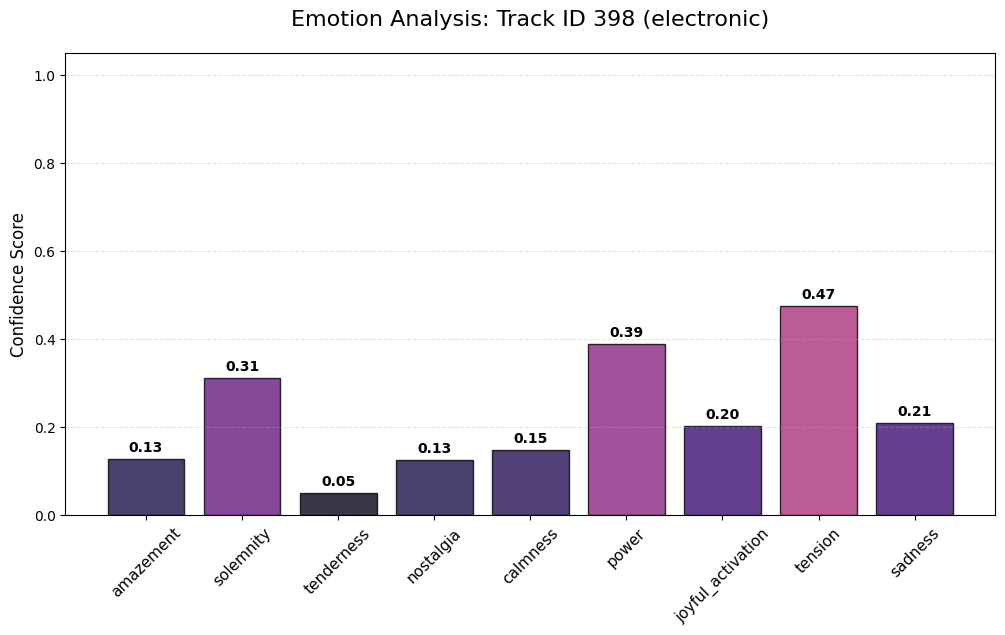

True Labels (Ground Truth):
DataFrame columns: ['songs_path', 'amazement', 'solemnity', 'tenderness', 'nostalgia', 'calmness', 'power', 'joyful_activation', 'tension', 'sadness']
Existing emotion columns in DataFrame: ['amazement', 'solemnity', 'tenderness', 'nostalgia', 'calmness', 'power', 'joyful_activation', 'tension', 'sadness']
{'amazement': 0.0909090909090909, 'solemnity': 0.5454545454545454, 'tenderness': 0.0454545454545454, 'nostalgia': 0.0454545454545454, 'calmness': 0.0909090909090909, 'power': 0.4545454545454545, 'joyful_activation': 0.0454545454545454, 'tension': 0.3181818181818182, 'sadness': 0.1363636363636363}


In [14]:
# Load metadata to find song paths
df = pd.read_csv('data/emotify_dataset/cleaned_metadata_weighted_probabilities.csv')
# Clean column names by stripping leading/trailing whitespace
df.columns = df.columns.str.strip()

# --- PICK A SONG TO DEMO ---
# Good candidates to try: 0, 10, 50, 110
song_idx = 398

path = 'data/emotify_dataset/' + df.iloc[song_idx]['songs_path']
title = f"Track ID {song_idx} ({df.iloc[song_idx]['songs_path'].split('/')[0]})"

# RUN DEMO
_ = predict_and_plot(path, title)

# Optional: Print True values to show accuracy
print("True Labels (Ground Truth):")
print(f"DataFrame columns: {df.columns.tolist()}") # Debug print
# Filter EMOTIONS to only include columns present in the DataFrame
existing_emotion_cols = [emo for emo in EMOTIONS if emo in df.columns]
print(f"Existing emotion columns in DataFrame: {existing_emotion_cols}") # Debug print
print(df.iloc[song_idx][existing_emotion_cols].to_dict())